In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setup Random Selection of Model Parameters

In [2]:
ModelRangesDict = {
        'NorthSea' : {
            'ChlGroups': ['diatoms', 'dinofl', 'coccol', 'c1'],
            'ChlGroupsNo': [0, 1, 2, 3],
            'ChlGroupFreq': [4, 4, 1, 1],
            'ChlDepMin': np.array(0), # which ranges occur for component iy, if component ix is the dominant one? here: minimum conc.
            'ChlDepMax': np.array(0), # which ranges occur for component iy, if component ix is the dominant one? here: maximum conc.
            'totChla' : [0.01, 100.],
            'diatoms': [0., 100.],
            'dinofl': [0., 100.],
            'coccol': [0., 100.],
            'c1': [0., 5.],
            'aCDOM': [0, 5.],
            'NAP': [0., 30.],
            's_cdom': [],  #Babin et al 2003b: 0.0176+-0.002 1/nm(European coastal waters), Shun 2023: 0.0174 +-0.0014 1/nm
            'L_FL': [],
            'bbpbp_ratio_bd': [],
            'bbpbp_ratio_md': [],
            'N_parameter': 10
        },
        'BalticSea' : {},
        'Ocean' : {
            'ChlGroups': ['coccol', 'c1'],
            'ChlGroupFreq': [1, 8],
            'coccol': [0., 10.],
            'c1': [0., 1.],
            'aCDOM': [0, 1.],
            'NAP': [0., 1.],
            's_cdom': [],
            'L_FL': [],
            'bbpbp_ratio_bd': [],
            'bbpbp_ratio_md': []
        },
        'fullDB' : {}
    }
 ShunBiColDict = {
        'diatoms': 0,
        'green': 1,
        'crypto': 2,
        'cyanoR': 3,
        'cyanoB': 4,
        'coccol': 5,
        'c1': 6,
    }
BioOpticsColDict = {
        'diatoms': 'C_0',
        'green': 'C_1',
        'crypto': 'C_2',
        'cyanoR': 'C_3',
        'cyanoB': 'C_4',
        'coccol': 'C_5',
        'dinofl': 'C_6',
        'c1': 'C_7',
    }

In [3]:
# Parameter selection
N = 5000
rangeType='NorthSea'
outpath = "E:\Documents\projects\EnsAD\simulations_PhytoGroups\\"

In [4]:
###
# Chlorophyll / Phytoplankton mixture model
###
ModelRanges = ModelRangesDict[rangeType]
total_chl = np.random.uniform(ModelRanges['totChla'][0], ModelRanges['totChla'][1], N)
Group0List = []
dominantGroupNoArray = np.zeros((N, len(ModelRanges['ChlGroups']))) + np.nan
c_groupArray = np.zeros((N, len(ModelRanges['ChlGroups'])))
for g, n in zip(ModelRanges['ChlGroupsNo'], ModelRanges['ChlGroupFreq']):
    [Group0List.append(g) for i in range(n)]

# select dominant group 1
dominantGroupNoArray[:, 0] = np.random.choice(Group0List, replace=True, size=N)
# select concentration for dominant group
for gID in ModelRanges['ChlGroupsNo']:
    ID = np.array(dominantGroupNoArray[:, 0] == gID)
    a = np.zeros(np.sum(ID))
    for j in range(len(a)):
        group = ModelRanges['ChlGroups'][gID]
        if total_chl[ID][j] * 0.3 < ModelRanges[group][1]:
            a[j] = np.random.uniform(total_chl[ID][j] * 0.3, ModelRanges[group][1], 1)
        else:
            a[j] = np.random.uniform(ModelRanges[group][0], ModelRanges[group][1], 1) # particularly for c1 with lower upper limits

    c_groupArray[ID, 0] = a

##todo: check, if max value of dominant group is exceeded!

## second Group and more
for i in range(N):
    Group0List_ = np.copy(np.asarray(Group0List))
    #todo: check, whether second dominant group is plausible (as function of c_groupArray[i, 0])
    col = 1
    addSecondDominantGroup = True
    if addSecondDominantGroup:
        delta = total_chl[i] - c_groupArray[i, 0]
        if delta > 0.:
            ID = np.array(Group0List_ != dominantGroupNoArray[i, 0])
            Group0List_ = Group0List_[ID]

            #select group 2
            dominantGroupNoArray[i, 1] = np.random.choice(Group0List_, replace=True, size=1)
            # todo: ranges here have to come from the dependend ranges (ChlDepMin, ChlDepMax)
            group = ModelRanges['ChlGroups'][int(dominantGroupNoArray[i, col])]
            if total_chl[i] * 0.3 < ModelRanges[group][1]:
                c_groupArray[i, col] = np.random.uniform(total_chl[i] * 0.3, ModelRanges[group][1], 1)
            else:
                c_groupArray[i, col] = np.random.uniform(ModelRanges[group][0], ModelRanges[group][1], 1)

            delta = total_chl[i] - np.sum(c_groupArray[i, 0:(col+1)])
            if delta < 0.:
                c_groupArray[i, col] = total_chl[i] - c_groupArray[i, 0]

        else:
            c_groupArray[i, col-1] = total_chl[i]

        col +=1

    # no second dominant group, use random selection
    if col < len(ModelRanges['ChlGroups']):
        for j in range(len(ModelRanges['ChlGroups']) - col):
            delta = total_chl[i] - np.sum(c_groupArray[i, 0:col])
            if delta > 0.:
                ID = np.array(Group0List_ != dominantGroupNoArray[i, col-1])
                Group0List_ = Group0List_[ID]
                #select group col
                dominantGroupNoArray[i, col] = np.random.choice(Group0List_, replace=True, size=1)
                group = ModelRanges['ChlGroups'][int(dominantGroupNoArray[i, col])]
                c_groupArray[i, col] = np.random.uniform(ModelRanges[group][0], ModelRanges[group][1], 1)

                delta = total_chl[i] - np.sum(c_groupArray[i, 0:(col + 1)])
                if delta < 0.:
                    c_groupArray[i, col] = total_chl[i] - np.sum(c_groupArray[i, 0:col])

            else:
                c_groupArray[i, col] += delta
                break

            col += 1

## fill in the concentrations in the output array. Columns are sorted by type!
notNaNArray = np.logical_not(np.isnan(dominantGroupNoArray))
dominantGroupNoArray = np.asarray(dominantGroupNoArray, dtype='int16')
out = np.zeros(dominantGroupNoArray.shape)
for i in range(N):
    ID = np.transpose(dominantGroupNoArray[i,:])[notNaNArray[i,:]]
    values = c_groupArray[i,:][notNaNArray[i,:]]
    for j, ind in enumerate(ID):
        out[i, ind] = values[j]

outDF = pd.DataFrame()
for j, var in enumerate(ModelRanges['ChlGroups']):
    outDF[var] = out[:, j]

outDF['totChl'] = total_chl

# 
# outDF.to_csv(outpath + "test_simulation_setup1.txt", header=True, sep='\t')

C:\Users\Dagmar\AppData\Local\Temp\ipykernel_16780\2293026833.py:83: RuntimeWarning: invalid value encountered in cast
  dominantGroupNoArray = np.asarray(dominantGroupNoArray, dtype='int16')


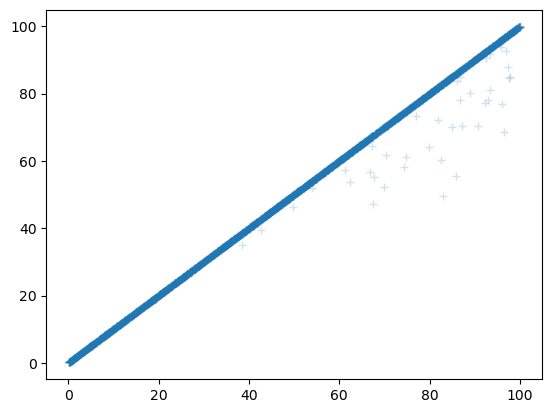

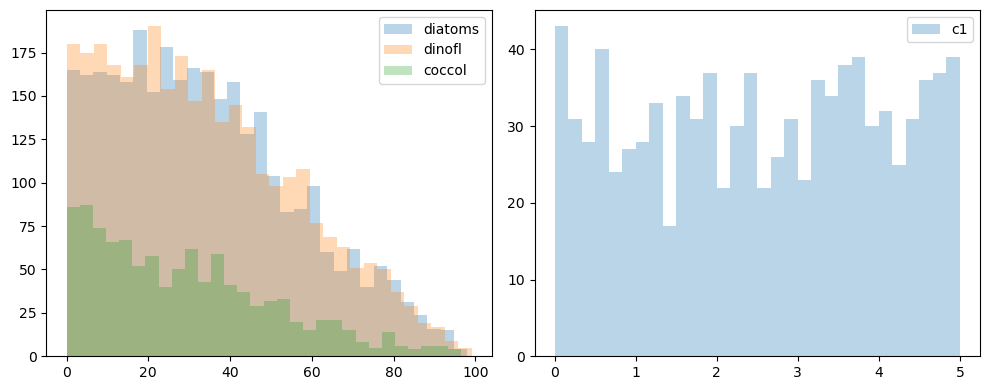

In [5]:
#if diagnostic_plot:
plt.plot(outDF['totChl'].values, np.sum(out, axis=1), '+', alpha=0.2)
plt.show()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
for j, var in enumerate(ModelRanges['ChlGroups']):
    ID = np.array(outDF[var].values > 0.)
    if var == 'c1':
        ax[1].hist(outDF[var].values[ID], 30, label=var, alpha=0.3)
    else:
        ax[0].hist(outDF[var].values[ID], 30, label=var, alpha=0.3)
ax[1].legend()
ax[0].legend()
fig.tight_layout()
plt.show()

In [ ]:
###
# NAP
###
NAP = np.random.uniform(ModelRanges['NAP'][0], ModelRanges['NAP'][1], N)  #todo: covariance with total_chl??
bbp_bp_bulk = np.random.uniform(ModelRanges['bbpbp_ratio_bd'][0], ModelRanges['bbpbp_ratio_bd'][1], N)  # higher ranges with cyanobacteria!


In [ ]:
###
# aCDOM
###
A_chl_ = pd.read_csv(
        "E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\phytoplankton_specific_absorption_aphi_HEREON_Shun2023.txt",
        sep='\t', header=0, comment='#')
ID = np.array(A_chl_['wl'] == 440.)
A_chl440 = A_chl_.loc[ID, :]
## Dinoflagellate spectrum from WASI auxiliary data
A_chl_dino_ = pd.read_csv("C:\WASI6\DATA\DINOFLAGELLATES.A", header=None, skiprows=11, sep='   ')
A_chl_dino_.columns = ['wl', 'aphi_star']
ID = np.array(A_chl_dino_['wl'] == 440.)
A_dino_chl440 = A_chl_dino_.loc[ID, :]

aphi440 = np.zeros(N)
for group in ModelRanges['ChlGroups']:
    if group == 'dinofl':
        aphi440 += A_dino_chl440['aphi_star'].values * outDF[group]
    else:
        aphi440 += A_chl440.iloc[:, ShunBiColDict[group] + 1].values * outDF[group]
s_cdom = np.random.uniform(0.01, 0.02, N) #Shun Bi table
R = np.random.sample(N)
p1 = 0.3 + (5.7*R*aphi440)/(0.02 + aphi440)
acdom = p1 * aphi440  #covariance with total_chl from IOCCG 2006 two-term model

In [ ]:
 ###
# Fluorscence parameters
###
FL_chl = np.random.uniform(0., 0.05, N)
# todo: smaller, when totChl is higher! quenching
FL_chl_Npeaks = np.zeros(N)  #todo: correlation with total_chl??
if 'cyanoB' in ModelRanges['ChlGroups']:
    Fl_phycoerythrin = np.random.uniform(0., 0.05, N)  # only with cyanoB
    # todo: smaller, when cyanoB is higher! quenching
if 'cyanoR' in ModelRanges['ChlGroups']:
    # todo: smaller, when cyanoR is higher! quenching
    FL_phycocyanin = np.random.uniform(0., 0.05, N)  # only with cyanoR

In [ ]:
### output for bio_optics
# C_0	C_1	C_2	C_3	C_4	C_5	C_6	C_7	C_Y	C_ism	L_fl_lambda0	L_fl_phycocyanin	L_fl_phycoerythrin
# b_ratio_C_0	b_ratio_C_1	b_ratio_C_2	b_ratio_C_3	b_ratio_C_4	b_ratio_C_5	b_ratio_C_6	b_ratio_C_7	b_ratio_d
# A_md	A_bd	S_md	S_bd	S_cdom	C_md	C_bd	K
# lambda_0_cdom	lambda_0_md	lambda_0_bd	lambda_0_c_d	lambda_0_phy
# gamma_d	x0	x1	x2	A	E0	E1	W
# fwhm1	fwhm2	fwhm_phycocyanin	fwhm_phycoerythrin	lambda_C1	lambda_C2	lambda_C_phycocyanin	lambda_C_phycoerythrin
# double	interpolate	Gw0	Gw1	Gp0	Gp1	error_method	theta_sun	theta_view	n1	n2	kappa_0	fresh
# T_W	T_W_0	P	AM	RH	H_oz	WV	alpha	beta	g_dd	g_dsr	g_dsa	d_r	f_dd	f_ds	offset	fit_surface	C_phy

## create output table with the changed parameters only!
outDF2 = pd.DataFrame()
for group in ModelRanges['ChlGroups']:
    outDF2[BioOpticsColDict[group]] = outDF[group]
outDF2['C_Y'] = acdom
outDF2['C_ism'] = NAP
outDF2['L_fl_lambda0'] = FL_chl
if 'cyanoR' in ModelRanges['ChlGroups']:
    outDF2['L_fl_phycocyanin'] = FL_phycocyanin  # only with cyanoR
if 'cyanoB' in ModelRanges['ChlGroups']:
    outDF2['lambda_C_phycoerythrin'] = Fl_phycoerythrin  # only with cyanoB
outDF2['b_ratio_d'] = bbp_bp_bulk
outDF2['S_cdom'] = s_cdom
outDF2.to_csv(outpath + "test_simulation_" +rangeType+"_version1_N"+str(int(N))+".txt", header=True, sep='\t')

# Analyse previously defined parameters

In [8]:
outpath = "E:\Documents\projects\EnsAD\simulations_PhytoGroups\\"
N = 50000
rangeType='NorthSea'
outDF2 = pd.read_csv(outpath + "test_simulation_" +rangeType+"_version1_N"+str(int(N))+".txt", header=0, sep='\t')

In [ ]:
for p in 